In [2]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
np.random.seed(2)

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [3]:
# Choose the variable you want to predict
country = 'South Korea'   # Choose from South Korea, India, US, United Kingdom
term = 'Confirmed'        # Choose from Confirmed, Recovered, Deaths
timestep = 14             # Choose the time step: n previous days' data -> the next 1 day's data

In [4]:
#----------- Tool: Visualization Function -----------
def plotPvsA(prediction, actual, dataset, term, country):
    # Plot those predictions
    plt.figure(figsize=(12,5))
    plt.plot(prediction, label='Predicted')

    # Plot the actual values
    plt.plot(actual, label='Actual')

    plt.title('Predicted vs Actual {} Cases of {} - {}'.format(term,country,dataset))
    plt.xlabel("Number of Days")
    plt.ylabel("Number of Cases")
    plt.legend()
    plt.savefig('{} Cases of {} - {}.png'.format(term,country,dataset))
    plt.show()
    return plt

In [5]:
#--------------- Data preprocessing: load, scale, split ---------------
# Import the dataset
dataset = pd.read_csv('dataset/'+country+'.csv')

# Split training, validation and test dataset
total_size = len(dataset)
train_size = 324              # 80:20 for traing and validation      
test_size = 20                # No. of days for prediction and test

Train = dataset.loc[0:train_size-1]                             # Train: 2020/1/22-2020/12/10
Val = dataset.loc[train_size-timestep:total_size-test_size-1]   # ValY: 2020/12/11~2021/2/26                                          
Test = dataset.loc[total_size-test_size:]                       # Test: 2021/2/27-2021/3/18

if term == 'Confirmed':
    train = Train.iloc[:, 1:2].values    
    val = Val.iloc[:, 1:2].values
    test = Test.iloc[:, 1:2].values
if term == 'Recovered':
    train = Train.iloc[:, 2:3].values
    val = Val.iloc[:, 2:3].values 
    test = Test.iloc[:, 2:3].values
if term == 'Deaths':
    train = Train.iloc[:, 3:4].values
    val = Val.iloc[:, 3:4].values 
    test = Test.iloc[:, 3:4].values
       
# Normalize data
sc = MinMaxScaler(feature_range=(0, 1))
train_norm = sc.fit_transform(train)   
val_norm = sc.transform(val)            
test_norm = sc.transform(test) 

In [6]:
# Create training set
trainX, trainY = [], []
for i in range(len(train_norm) - timestep):
    trainX.append(train_norm[i:(i + timestep)])
    trainY.append(train_norm[i + timestep, 0])
trainX, trainY = np.array(trainX), np.array(trainY)  
    # input_shape for the LSTM model:（samples, time_steps, features）

In [7]:
# Create validation set
valX, valY = [], []
for i in range(len(val_norm) - timestep):
    valX.append(val_norm[i:(i + timestep)])
    valY.append(val_norm[i + timestep, 0])
valX, valY = np.array(valX), np.array(valY) 

In [7]:
#------------------- LSTM model: initialize, train -------------------
# Initialize the model
model = Sequential()

# Add the first LSTM layer and Dropout regularisation
model.add(LSTM(units = 45, return_sequences = True, input_shape = (timestep,1), activation = "relu"))
model.add(Dropout(0.2))

# Add a second LSTM layer and Dropout regularisation
model.add(LSTM(units = 45, return_sequences = True))  
model.add(Dropout(0.2))

# Add a third LSTM layer and Dropout regularisation
model.add(LSTM(units = 25))
model.add(Dropout(0.2))

# Add the output dense layer
model.add(Dense(units = 1))   

# Compile the model
model.summary()
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fit the model to the training set and validate with the val set
# Set the early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
# Reduce the learning rate automatically
learn_rate = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.8, min_lr=0.00001,mode='min')
history = model.fit(trainX, trainY, epochs = 200 , batch_size = 8, validation_data = (valX, valY), verbose=1, callbacks=[learn_rate,earlystop]) 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 14, 45)            8460      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 45)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 45)            16380     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 45)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                7100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

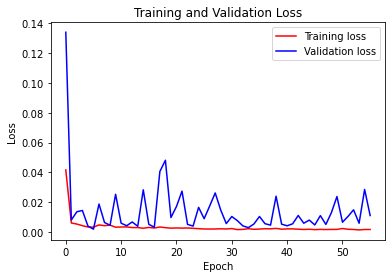

In [8]:
# Plot train and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('Loss - {} Cases of {}.png'.format(term,country))
plt.show()

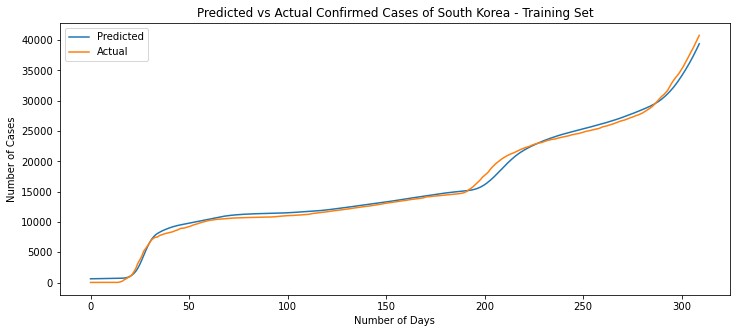

In [9]:
#--------------------- Evaluation ---------------------
# Visualization of the prediction on the training set
n = trainX.shape[0]   # No. of days to be visualized, n last available trainX
predT = []
for i in range(n):
    predT.append(model.predict(trainX[-n+i].reshape(1,timestep,1))) 

# Transform values back to their normal format
predT = np.array(predT).reshape(-1,1)
predT_ori = sc.inverse_transform(predT)

# Get the actual values from the last available y variable which correspond to its respective X variable
actT = train[-n:]  

# Plot Predicted vs Actual
plotT = plotPvsA(predT_ori, actT, 'Training Set', term, country)

In [10]:
# Evaluation of the training set
mseT = mean_squared_error(actT, predT_ori)
rmseT = sqrt(mseT)
rT = r2_score(actT, predT_ori)
print(mseT,rmseT,rT)

398565.2516258847 631.3202449041886 0.9950580890488445


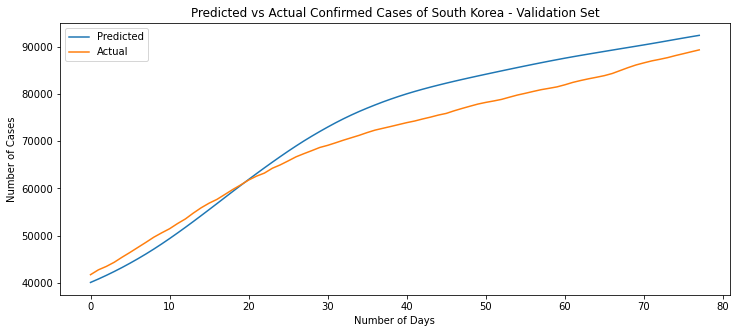

In [11]:
# Validation and evaluation of the validation set 
predV = model.predict(valX)  # Make prediction for the validation set
predV_ori = sc.inverse_transform(predV) 
actV = val[-len(predV):]

# Plot Predicted vs Actual
plotV = plotPvsA(predV_ori, actV, 'Validation Set', term, country)

In [12]:
# Evaluation of the validation set
mseV = mean_squared_error(actV,predV_ori)
rmseV = sqrt(mseV)
rV = r2_score(actV,predV_ori)
print(mseV,rmseV,rV)

18509384.145862482 4302.253380016394 0.8966175439256392


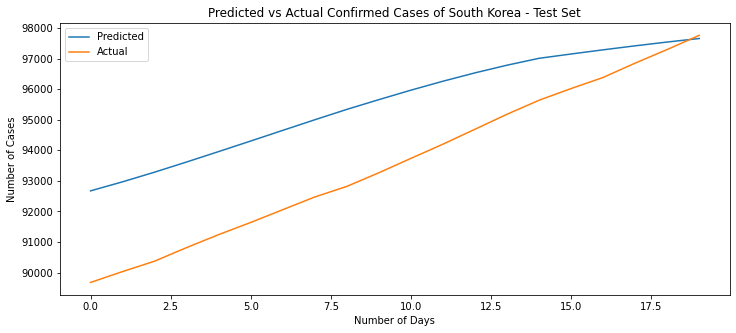

In [13]:
#----------------- Make predictions on the test set or more -----------------
# Number of days to be predicted
future = 20   # ≥ test_size

# Initialize the prediction dataset, future=1
predP = []
predX = val_norm[-timestep:].reshape(1,timestep,1)                  
predY = model.predict(predX)                                        
predP.append(predY[0])

# Predict unknown future data
for i in range(future-1):              # loop (future-1) times
    predX = np.concatenate((predX[:,1:,:], predY.reshape(1,1,1)),axis = 1)  # use predicted data to fit
    predY = model.predict(predX)
    predP.append(predY[0])
predP_ori = sc.inverse_transform(predP)

# Plot Predicted vs Actual
plotP = plotPvsA(predP_ori, test, 'Test Set', term, country)


In [14]:
# Evaluation on the test set
mse = mean_squared_error(test,predP_ori[:test_size])
rmse = sqrt(mse)
r = r2_score(test,predP_ori[:test_size])
print(mse,rmse,r)

# Print the accuracy table of the test result (Cumulative Cases)
accuracy = 1-abs((predP_ori[:test_size]-test)/test)
acc_table = pd.DataFrame(accuracy)
acc_table.columns = ['Accuracy']
acc_table.index = [list(range(1,test_size+1))]
print(acc_table)

4654711.3221614305 2157.478000388748 0.24525498993982808
    Accuracy
1   0.966605
2   0.967390
3   0.967792
4   0.969175
5   0.970228
6   0.970940
7   0.971816
8   0.972693
9   0.972865
10  0.974359
11  0.976199
12  0.978143
13  0.980524
14  0.983135
15  0.985661
16  0.988230
17  0.990624
18  0.994161
19  0.997490
20  0.998945


In [15]:
# Print the accuracy table of the test result (Daily Increased Cases)
# Predicted daily increased cases
Case1_pred = np.vstack((predV_ori[-1],predP_ori[:test_size-1]))  # 1 day before
Case2_pred = predP_ori[:test_size]                               # 1 day after
Increased_pred = Case2_pred - Case1_pred
# Actual daily increased cases
Case1 = np.vstack((val[-1],test[:test_size-1]))
Case2 = test[:test_size]
Increased = Case2 - Case1

acc_inc = 1-abs((Increased_pred -Increased)/Increased)
acc_inc_table = pd.DataFrame(acc_inc)
acc_inc_table.columns = ['Accuracy']
acc_inc_table.index = [list(range(1,test_size+1))]
print(acc_inc_table)

    Accuracy
1   0.774522
2   0.834338
3   0.925966
4   0.749441
5   0.804080
6   0.865867
7   0.835812
8   0.833077
9   0.981383
10  0.714641
11  0.658763
12  0.629816
13  0.559921
14  0.512311
15  0.490686
16  0.368439
17  0.376259
18  0.279028
19  0.277994
20  0.249713


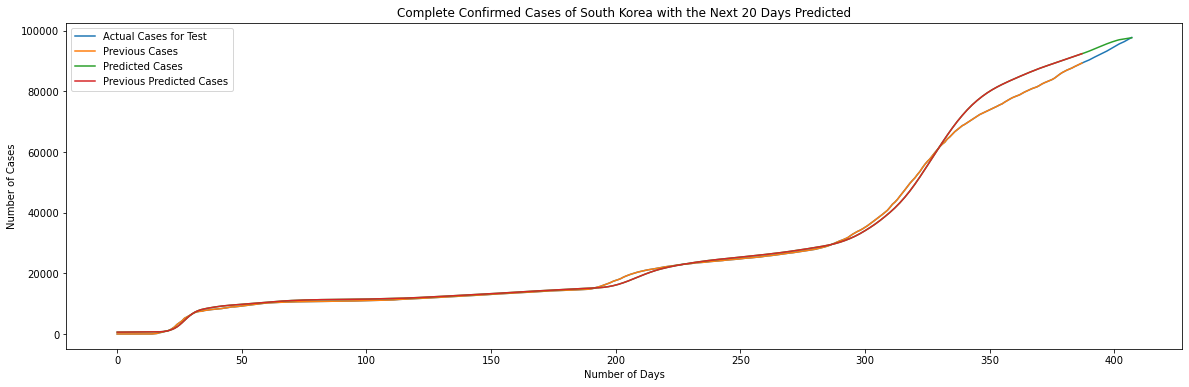

In [16]:
# Plot the complete graph
# all the previous data (start from day15)
previous = np.append(actT, actV, axis=0)  
# all the actual data (+test) (start from day15)
All_act = np.append(previous, test, axis=0)
# all the previous predicted data
previous_pred = np.append(predT_ori,predV_ori,axis=0)
# all the predicted data
All_pred = np.append(previous_pred, predP_ori, axis=0) 

# Plot
plt.figure(figsize=(20,6))
plt.plot(All_act, label="Actual Cases for Test")
plt.plot(previous, label="Previous Cases")
plt.plot(All_pred, label="Predicted Cases")
plt.plot(previous_pred, label="Previous Predicted Cases")
plt.ylabel("Number of Cases")
plt.xlabel("Number of Days")
plt.title("Complete {} Cases of {} with the Next {} Days Predicted".format(term,country,future))
plt.legend()
plt.savefig("Predictions, {}, {}.png".format(country,term))
plt.show()

In [17]:
print(mseT,rmseT,rT)
print(mseV,rmseV,rV)
print(mse,rmse,r)

398565.2516258847 631.3202449041886 0.9950580890488445
18509384.145862482 4302.253380016394 0.8966175439256392
4654711.3221614305 2157.478000388748 0.24525498993982808
